In [1]:
import generalized_rashomon_set as grs
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, TensorDataset
import torch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from src.Utilities import load_data, m_training_process_vis, plot_feature_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns; sns.set()
sns.set(color_codes=True)
sns.set(font_scale=1.2)
#plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-09-05 12:05:39,372 INFO config <module> The output directory is E:\projects\Batteries\MXen-in-Rashomon-set\experiments/../results
 The log directory is E:\projects\Batteries\MXen-in-Rashomon-set\experiments/../logs


## Conventional workflow
### Load data from csv file

In [2]:
X_df = load_data(filename='../data/data_withLattice.csv')
X_features = X_df.iloc[:,1:-5]
feature_names = X_features.columns.values

y_multilabel = X_df.iloc[:,-5:]
label_names = y_multilabel.columns.values

print('Feature names: \n', feature_names)
print('Label names: ', label_names)

Feature names: 
 ['Sc' 'Ti' 'V' 'Cr' 'Zr' 'Nb' 'Mo' 'Hf' 'Ta' 'C' 'N' 'F' 'H' 'O' 'OH'
 'NULL' 'Li' 'Na' 'K' 'Mg']
Label names:  ['Voltage(V)' 'Theoretical_capacity (mAh/g)' 'Induced_Z_charge(mAh/g)'
 'In-plane lattice' 'In-plane lattice(intercalated)']


## Elemental descriptor

In [3]:
X = X_features.to_numpy()
y = y_multilabel.to_numpy()
scaler = preprocessing.MinMaxScaler()
y = scaler.fit_transform(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.9, train_size=0.1, random_state=42)

In [5]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)
val_dataset = TensorDataset(X_val_tensor,y_val_tensor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)

In [6]:
from train_nn_elemental_descriptor import Net_ele_descriptor
model = Net_ele_descriptor()
model.load_state_dict(torch.load('../results/model/best_model_ANN_ele_descriptor.pth'))
model.eval()

Net_ele_descriptor(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [10]:
print('The MSE loss of trained NN on the test set is {}, MAE is {}, R2 is {}, training process is illustrated below'.format(mean_squared_error(y_test, model(X_test_tensor).detach().numpy()), mean_absolute_error(y_test, model(X_test_tensor).detach().numpy()), r2_score(y_test, model(X_test_tensor).detach().numpy())))
print('The R2 of trained NN on the training set is {}'.format(r2_score(y_train, model(X_train_tensor).detach().numpy())))

The MSE loss of trained NN on the test set is 0.003545221429311704, MAE is 0.031805615767511744, R2 is 0.9040671152435305, training process is illustrated below
The R2 of trained NN on the training set is 0.9957000266806773


## Training process

In [9]:
train_loss = np.load('../results/model/train_loss_ele_descriptor.npy')
test_loss = np.load('../results/model/test_loss_ele_descriptor.npy')

(0.0001596307835819993, 0.010187959371297505)

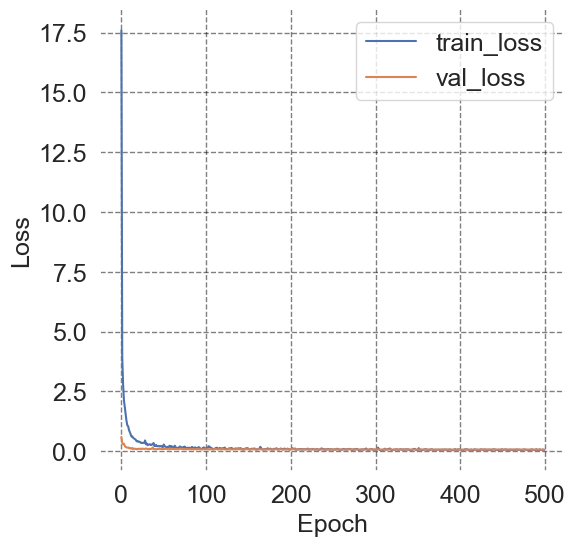

In [40]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.plot(train_loss[:], label='train_loss')
ax.plot(test_loss[:], label='val_loss')
ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(bbox_to_anchor=(1.0, 1.0), shadow=False, facecolor='white', fontsize=18)
ax.set_xlabel('Epoch',fontsize=18)
ax.set_ylabel('Loss',fontsize=18)
plt.savefig('../results/figs/training_process_ele_descriptor.png', bbox_inches='tight')
plt.show()

In [10]:
pred_train = model(X_train_tensor).detach().numpy()
pred_test = model(X_test_tensor).detach().numpy()

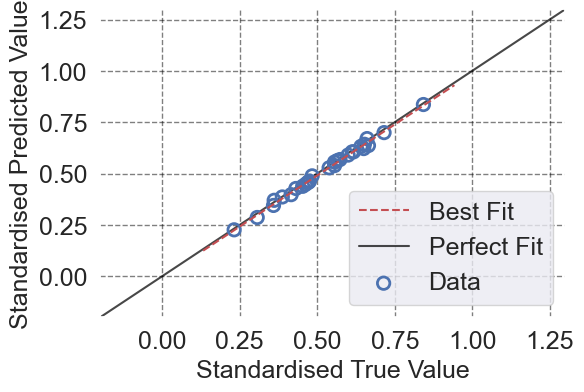

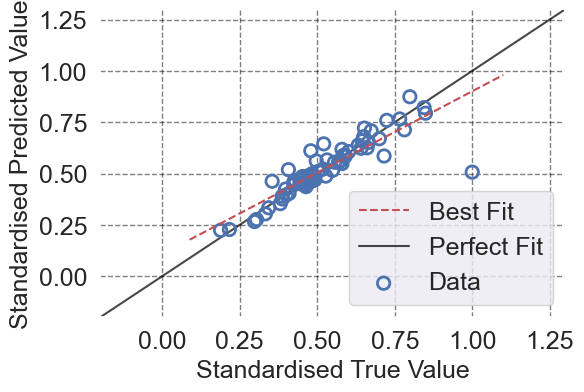

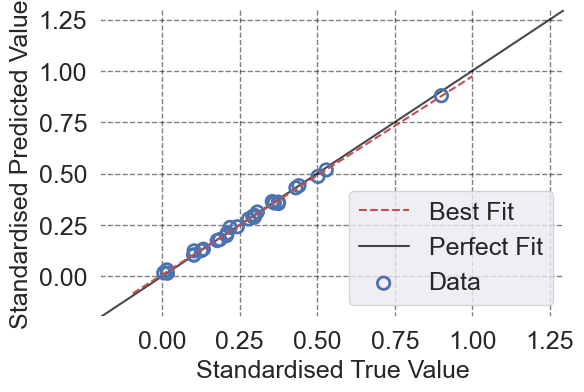

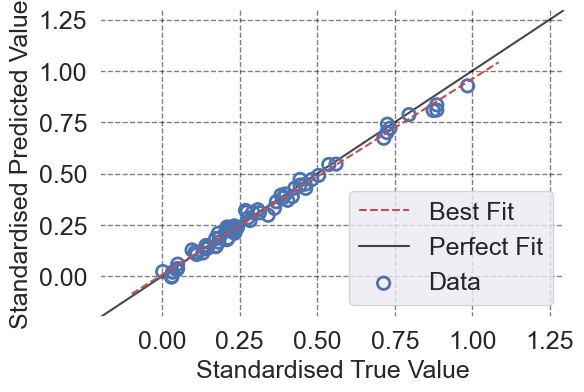

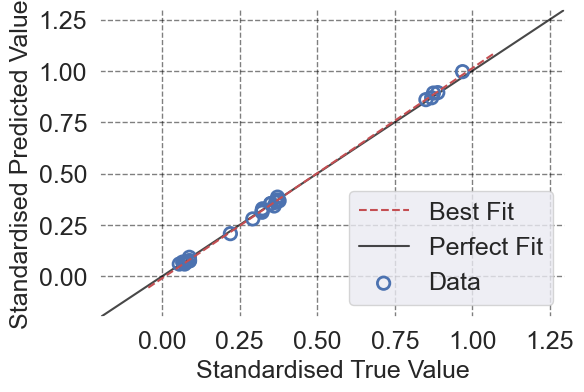

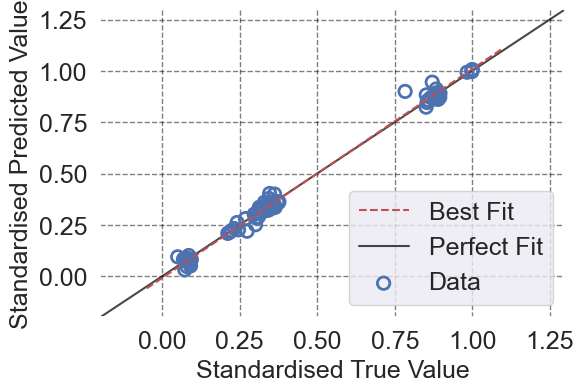

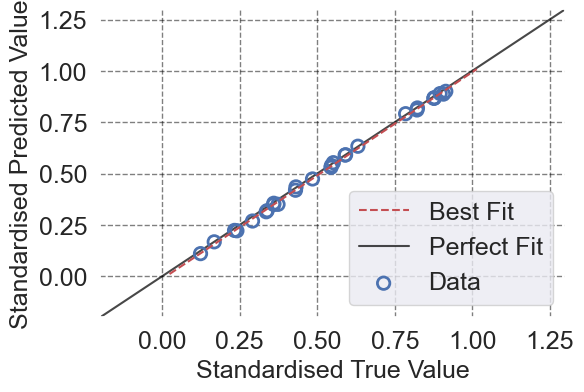

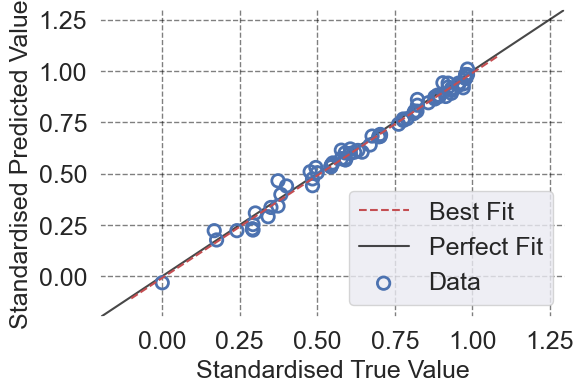

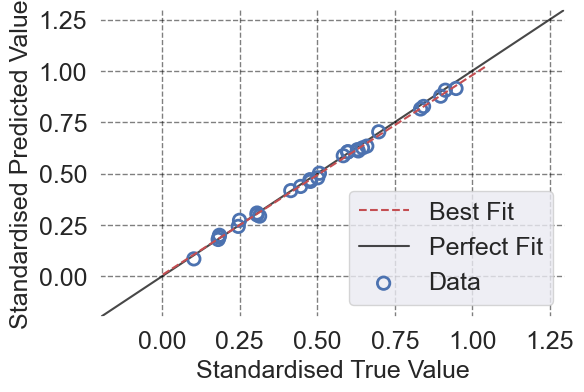

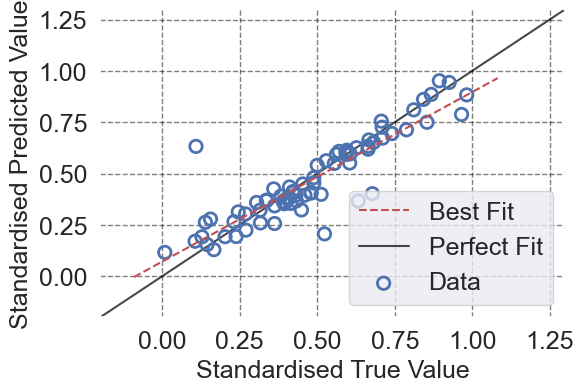

In [33]:
from src.Utilities import plot_gth_pre
for idx, label in enumerate(label_names):
    range_max = 1.3
    range_min = -0.2
    plot_gth_pre(y_train[:, idx], pred_train[:, idx], range_set=False, range_x=[range_min,range_max], range_y=[range_min,range_max],
                 tag='_Train_'+label[:20])
    plot_gth_pre(y_test[:, idx], pred_test[:, idx], range_set=False, range_x=[range_min,range_max], range_y=[range_min,range_max],
                 tag='_Test_'+label[:20])

## PCA results (ground truth vs predictions)

In [34]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)
z_nn = pca.fit_transform(y_test)
z_pred_nn = pca.fit_transform((model(X_test_tensor).detach().numpy()))

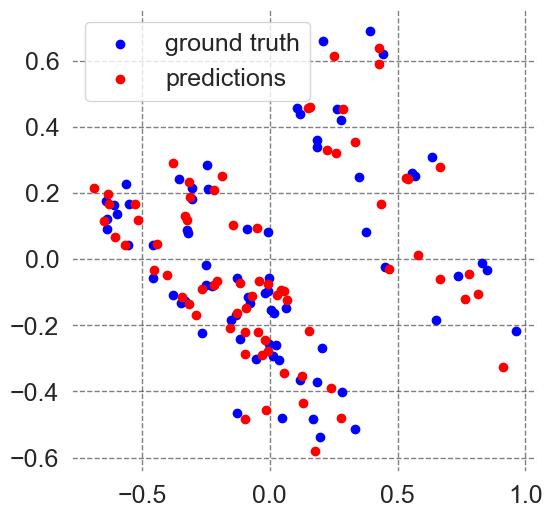

In [35]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ax.scatter(z_nn[:,0], z_nn[:,1], color='blue', label='ground truth')
ax.scatter(z_pred_nn[:,0], z_pred_nn[:,1], color='red', label='predictions')
# ax.set_axisbelow(True)
ax.xaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
ax.yaxis.grid(False, color ="black", linestyle='--', lw = 1, alpha=0.5)
# ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(loc=2, shadow=False, facecolor='white', fontsize=18)
# ax.set_xlabel('PCA',fontsize=18)
plt.savefig('../results/figs/pred_vs_gth_nn_ele.png', bbox_inches='tight')
plt.show()

## Sample from the Rashomon set

In [41]:
import os
ROOT_DIR = os.getcwd()
OUTPUT_DIR = ROOT_DIR+'/../results'

In [42]:
fis_explainer_mlp = grs.explainers.fis_explainer(model, X_test, y_test, epsilon_rate=0.1, loss_fn='regression', wrapper_for_torch=True)

2023-09-04 13:59:49,340 INFO _explainer __init__ You can call function explainer.load_results(results_path="") to load trained results if exist


In [43]:
fis_explainer_mlp.load_results('../results')

In [44]:
fis_explainer_mlp.ref_explain()

In [45]:
fis_explainer_mlp.rset_explain()

2023-09-04 14:00:25,153 INFO _explainer rset_explain Start exploring the possible models
2023-09-04 14:00:25,153 INFO _explainer rset_explain Already exists, skip
2023-09-04 14:00:25,154 INFO _explainer rset_explain Calculating all main effects of features range(0, 20) for all models in the Rashomon set
2023-09-04 14:00:25,154 INFO _explainer rset_explain Already exists, skip
2023-09-04 14:00:25,155 INFO _explainer rset_explain Already exists, skip
2023-09-04 14:00:25,155 INFO _explainer rset_explain Already exists, skip


## Feature importance from NN

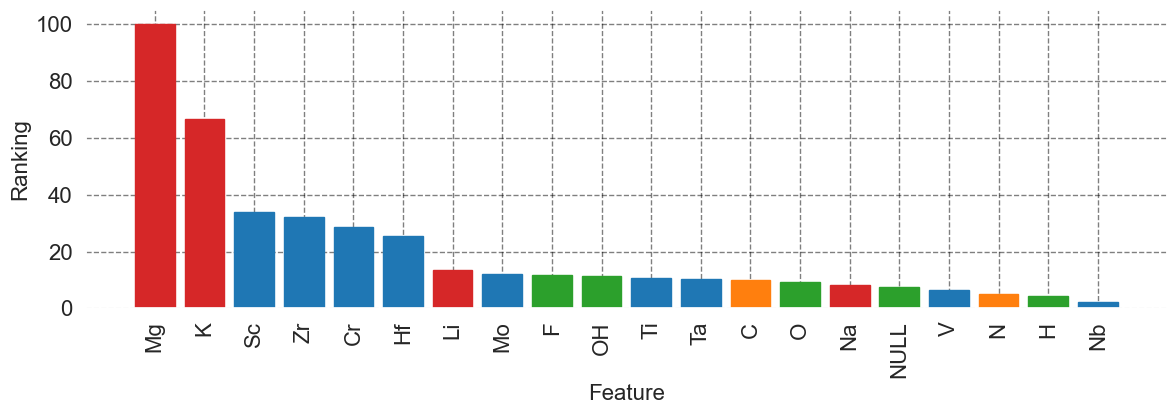

In [52]:
plot_feature_importance(
    X_features.columns,
    fis_explainer_mlp.ref_analysis['ref_main_effects'],
    show_cols = 20
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# plt.savefig('../results/figs/feature_importance_nn.png', dpi = 300, bbox_inches='tight')
plt.show()

## sampled Rashomon set at a glance

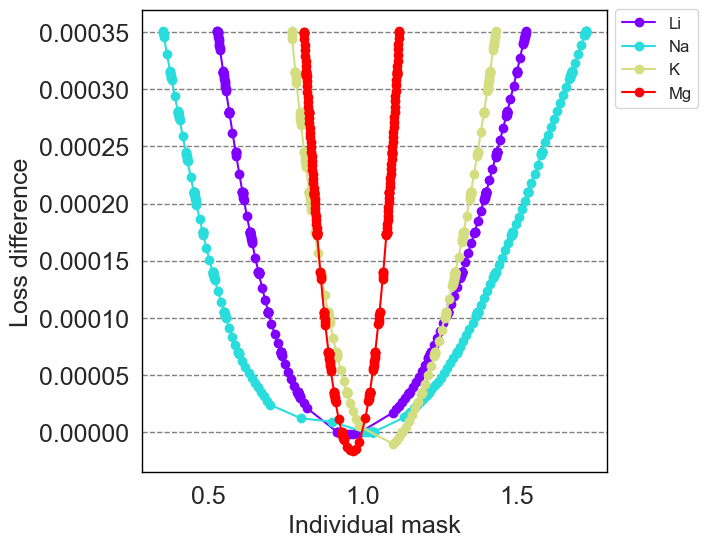

In [47]:
m_training_process_vis(fis_explainer_mlp.rset_main_effect_raw['points_all_max'][16:], fis_explainer_mlp.rset_main_effect_raw['points_all_min'][16:], feature_names[16:], save=False, suffix='NN-Z')

## Swarm plot

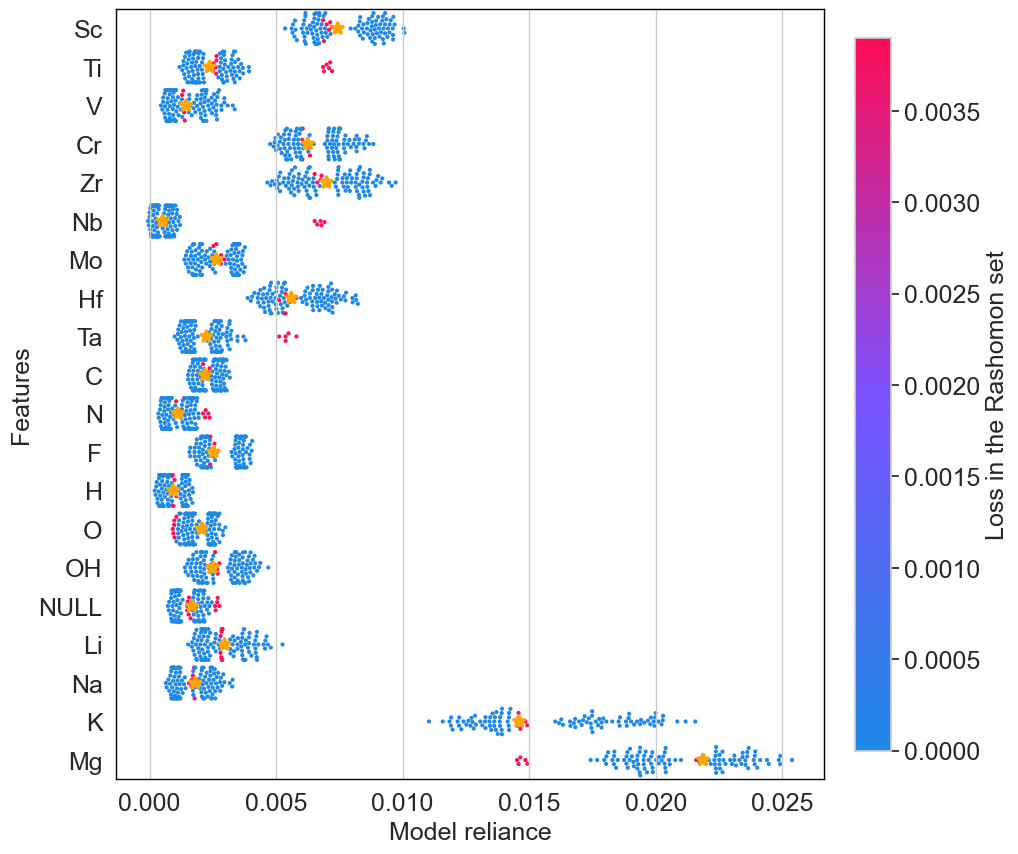

In [49]:
grs.plots.swarm_plot_MR(fis_explainer_mlp, interest_of_features = [0, 1 ,2 ,3] , vname = feature_names, plot_all = True, boxplot = False, save=False, suffix='NN')

## Feature importance from Rashomon set

In [53]:
feature_importance_uni = fis_explainer_mlp.feature_importance_uni(std=True)

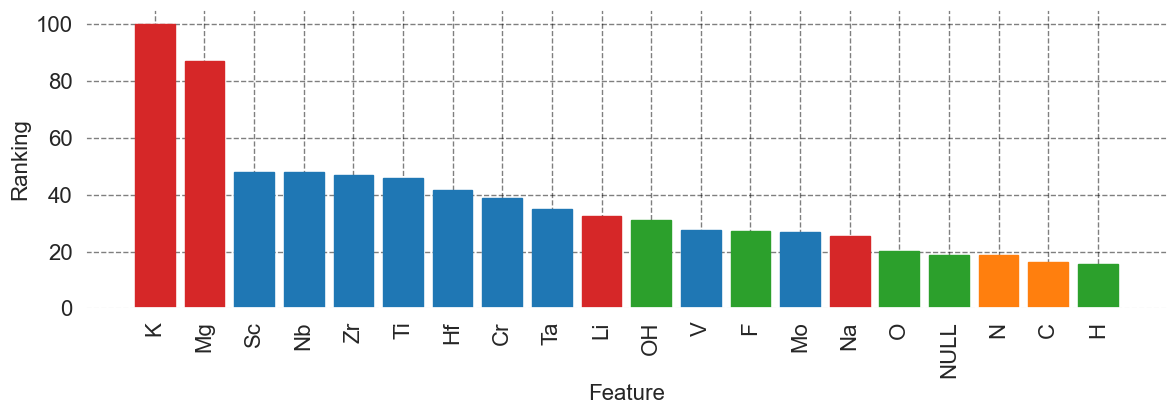

In [54]:
plot_feature_importance(
    X_features.columns,
    feature_importance_uni,
    show_cols = 20
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# plt.savefig('../results/figs/feature_importance_universal.png', dpi = 300, bbox_inches='tight')

## save results in a table

In [55]:
results_csv = np.zeros((20, 4))
for idx, i in enumerate(np.array(fis_explainer_mlp.rset_main_effect_processed['all_main_effects_diff']).transpose(
        (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))):
    results_csv[idx, 0] = np.average(i)
    results_csv[idx, 1] = np.min(i)
    results_csv[idx, 2] = np.max(i)
    results_csv[idx, 3] = np.std(i)
# np.savetxt("../results/figs/result.csv", results_csv, delimiter=",")

# Integrating domain knowledge and model selection

In [58]:
Mg_min = min(np.array(fis_explainer_mlp.rset_main_effect_processed[
            'all_main_effects_diff']).transpose(
            (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))[-1])
Nb_max = max(np.array(fis_explainer_mlp.rset_main_effect_processed[
            'all_main_effects_diff']).transpose(
            (2, 0, 1, 3)).reshape((len(fis_explainer_mlp.v_list), -1))[5])
print('In the Rashomon set, the minimum importance of Mg is {}, and the maximum importance of Nb is {}, which can be reflected in the feature importance ranking'.format(Mg_min, Nb_max))

In the Rashomon set, the minimum importance of Mg is 0.014519110351281629, and the maximum importance of Nb is 0.006917690786170076, which can be reflected in the feature importance ranking


## Application of prediction component
## Li intercalation and Oxygen Termination

In [152]:
Nb2COLi = np.zeros(20, dtype=np.double)
Nb2COLi[5], Nb2COLi[9], Nb2COLi[13], Nb2COLi[-4]= 1.0, 1.0, 1.0, 1.0
Ti2COLi = np.zeros(20, dtype=np.double)
Ti2COLi[1], Ti2COLi[9], Ti2COLi[13], Ti2COLi[-4] = 1.0, 1.0, 1.0, 1.0
V2COLi = np.zeros(20, dtype=np.double)
V2COLi[2], V2COLi[9], V2COLi[13], V2COLi[-4] = 1.0, 1.0, 1.0, 1.0
application = np.vstack((Nb2COLi, Ti2COLi, V2COLi))
application = torch.Tensor(application)
pred = model(application)

In [153]:
# The output is transformed back
scaler.inverse_transform(pred.detach().numpy())

array([[  1.0483372 , 221.13513   ,   0.62475777,   3.1203506 ,
          3.1185913 ],
       [  1.2018886 , 344.29114   ,   0.63228095,   3.0277283 ,
          3.014446  ],
       [  1.4004344 , 322.32834   ,   0.60617954,   2.8808563 ,
          2.9628277 ]], dtype=float32)